## Notes

### TODO
- Additional Experiments with different driving patterns
- Additional Experiments with different signal processing

### Overview
This notebook captures a series of tests performed on the Raspberry Pi 2 with the Adafruit BNO055 9-dof IMU sensor board.  The main goals for the tests were: 
- characterize the raw and filtered IMU measurements under a variety of platform conditions (e.g., stationary, constant linear motion, etc.)

### READ THIS BEFORE RUNNING
- Some of the following experiments depend on the PIGPIO daemon.  To activate the daemon process, execute the following command on the host machine for this notebook: "sudo pigpiod" (Note: This should be done before running the experiment cells that depend on it.)

### How to run this notebook
##### Launch jupyter notebook server on RPi
- From a local terminal session, log into the RPi on the rover
- run "source ~/.profile" to make sure virtualenvwrapper environment variables are set
- run "workon rover1" to launch the correct virtual environment
- cd to the repo root directory (nominally ~/nanibot)
- run "jupyter notebook --no-browser --port=[port #]" to launch the notebook server

##### Setup ssh tunneling and port forwarding on local machine
- run "ssh -N -f -L localhost:[port #]:localhost:[port #] pi@[RPi host IP]"
- From local browser, go to localhost:[port #]

### Implementation Details
- The implementation of the underlying periodic wakeups and serial communications were prototyped and documented in the following notebook: sandboxes/ipython_notebooks/imu_sample_rate_tests_3.ipynb
- The implementation of the syncronized Producer-Consumer, buffered data capture and signal processing where prototyped and documented in the following notebook: sandboxes/ipython_notebooks/imu_multiproc_sampling_and_buffering_test_1.ipynb

### Test Design
- Experiment 1: Stationary platform
- Experiment 2: Arbitrary, hand-held motion
- Experiment 3: Near-constant linear velocity
- Experiment 4: Varied linear accelerations
- Experiment 5: Varied 2-D accelerations
 
### Conclusions

### Next Steps


## Component Code

In [19]:
%matplotlib inline
from __future__ import division
import time
import sys
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from Adafruit_BNO055 import BNO055
import serial
from serial.serialutil import SerialException

In [2]:
# -- Define some configuration constants for the imu sensor --
CALIBRATION_FILE='/home/pi/nanibot/rover1/peripherals/bno055_imu/calibration/calibration.json'
CALIBRATION_DATA=[1, 0, 2, 0, 244, 255, 223, 255, 50, 1, 210, 255, 253, 255, 255, 255, 2, 0, 232, 3, 181, 2]

BNO_AXIS_REMAP = {
        'x': BNO055.AXIS_REMAP_Y,
        'y': BNO055.AXIS_REMAP_X,
        'z': BNO055.AXIS_REMAP_Z,
        'x_sign': BNO055.AXIS_REMAP_NEGATIVE,
        'y_sign': BNO055.AXIS_REMAP_POSITIVE,
        'z_sign': BNO055.AXIS_REMAP_POSITIVE }

In [3]:
# - Add the main rover source tree to sys.path so modules are accessible - 
rover1_path = '/home/pi/nanibot/rover1'
if rover1_path not in sys.path:
    sys.path.insert(0,rover1_path)
sys.path

['/home/pi/nanibot/rover1',
 '',
 '/usr/local/lib/python2.7/dist-packages/Adafruit_BNO055-1.0.1-py2.7.egg',
 '/usr/local/lib/python2.7/dist-packages/Adafruit_GPIO-1.0.0-py2.7.egg',
 '/usr/local/lib/python2.7/dist-packages/Adafruit_PureIO-0.2.0-py2.7.egg',
 '/usr/lib/python2.7/dist-packages',
 '/usr/lib/python2.7',
 '/usr/lib/python2.7/plat-arm-linux-gnueabihf',
 '/usr/lib/python2.7/lib-tk',
 '/usr/lib/python2.7/lib-old',
 '/usr/lib/python2.7/lib-dynload',
 '/usr/local/lib/python2.7/dist-packages',
 '/usr/lib/python2.7/dist-packages/gtk-2.0',
 '/usr/lib/pymodules/python2.7',
 '/usr/local/lib/python2.7/dist-packages/IPython/extensions',
 '/home/pi/.ipython']

In [4]:
# - Override some behavior of the off the shelf Adafruit module - 
class BNO055_2(BNO055.BNO055):
    def __init__(self, rst=None, address=BNO055.BNO055_ADDRESS_A, i2c=None, gpio=None,
                 serial_port=None, serial_timeout_sec=5, baudrate=115200, 
                 max_send_attempts=5, **kwargs):
        # If reset pin is provided save it and a reference to provided GPIO
        # bus (or the default system GPIO bus if none is provided).
        self._rst = rst
        if self._rst is not None:
            if gpio is None:
                import Adafruit_GPIO as GPIO
                gpio = GPIO.get_platform_gpio()
            self._gpio = gpio
            # Setup the reset pin as an output at a high level.
            self._gpio.setup(self._rst, GPIO.OUT)
            self._gpio.set_high(self._rst)
            # Wait a 650 milliseconds in case setting the reset high reset the chip.
            time.sleep(0.65)
        self._max_send_attempts=max_send_attempts
        self._serial = None
        self._i2c_device = None
        if serial_port is not None:
            # Use serial communication if serial_port name is provided.
            # Open the serial port at 115200 baud, 8N1.  Add a 5 second timeout
            # to prevent hanging if device is disconnected.
            self._serial = serial.Serial(serial_port, baudrate, timeout=serial_timeout_sec,
                                         writeTimeout=serial_timeout_sec)
        else:
            raise AttributeError('No valid serial interface specified.')
        # - Brief pause to make sure everything finishes initializing (maybe not necessary)
        time.sleep(0.001)
        
    def _serial_send(self, command, ack=True, max_attempts=5):
        # Send a serial command and automatically handle if it needs to be resent
        # because of a bus error.  If ack is True then an ackowledgement is
        # expected and only up to the maximum specified attempts will be made
        # to get a good acknowledgement (default is 5).  If ack is False then
        # no acknowledgement is expected (like when resetting the device).
        attempts = 0
        while True:
            # Flush any pending received data to get into a clean state.
            self._serial.flushInput()
            # Send the data.
            self._serial.write(command)
            #logger.debug('Serial send: 0x{0}'.format(binascii.hexlify(command)))
            # Stop if no acknowledgment is expected.
            if not ack:
                return
            # Read acknowledgement response (2 bytes).
            resp = bytearray(self._serial.read(2))
            #logger.debug('Serial receive: 0x{0}'.format(binascii.hexlify(resp)))
            if resp is None or len(resp) != 2:
                raise RuntimeError('Timeout waiting for serial acknowledge, is the BNO055 connected?')
            # Stop if there's no bus error (0xEE07 response) and return response bytes.
            if not (resp[0] == 0xEE and resp[1] == 0x07):
                return resp
            # Else there was a bus error so resend, as recommended in UART app
            # note at:
            #   http://ae-bst.resource.bosch.com/media/products/dokumente/bno055/BST-BNO055-AN012-00.pdf
            attempts += 1
            if attempts >=  self._max_send_attempts:
                raise RuntimeError('Exceeded maximum attempts to acknowledge serial command without bus error!')

In [5]:
# - Low level helper methods for sensor sampling logic
def wakeup_handler(signum, frame):
    global wakeup_set, wakeup_wrap
    if wakeup_set:
        wakeup_wrap = True
    wakeup_set = True

def initialize_sensor_itimer(wakeup_interval_usec):
    import signal
    # Define sigaction for SIGALRM
    signal.signal(signal.SIGALRM,wakeup_handler)
    signal.setitimer(signal.ITIMER_REAL,wakeup_interval_usec*1e-6,wakeup_interval_usec*1e-6)
    
def cleanup_itimer():
    import signal
    signal.setitimer(signal.ITIMER_REAL,0,0)

def finalize_wakeup_attempt():
    global wakeup_set, wakeup_count, read_started, read_completed
    wakeup_set = False
    wakeup_count += 1
    read_started = False
    read_completed = True
    

In [32]:
# - Main runnable for sensor sampling process
def run_serial_buffer_test_3(
    num_samples, 
    sample_interval_usec, 
    max_read_retries, 
    t_array,
    x_array, 
    y_array, 
    z_array,
    buffer_offset,
    buffer_full_condition,
    buffer_mutex,
    do_axis_remap=True,
    do_calibration=False,
    qw_array=None,
    qx_array=None,
    qy_array=None,
    qz_array=None):
    
    # Reset global variables (Probably necessary for repeated runs in iPython)
    global wakeup_count, wakeup_set, read_started, read_completed, wakeup_wrap
    wakeup_count = 0
    wakeup_set = 0
    read_started = 0
    read_completed = 0
    wakeup_wrap = 0
    
    # Compute operational constants
    max_time_sec = 10 * num_samples * sample_interval_usec * 1.0e-6 # Extra factor of 10, so we don't get cutoff prematurely

    
    # -- Create serial adapter and initialize BNO055 sensor --
    imu = BNO055_2(
        serial_port='/dev/ttyAMA0', 
        rst=18, 
        baudrate=115200,
        max_send_attempts=max_read_retries)
    # -- Reset bno and set to desired mode --
    mode = BNO055.OPERATION_MODE_NDOF
    #mode = BNO055.OPERATION_MODE_AMG
    #mode = BNO055.OPERATION_MODE_GYRONLY
    
    if not imu.begin(mode=mode):
        raise RuntimeError('Failed to initialize BNO055!')
    if do_axis_remap:
        imu.set_axis_remap(**BNO_AXIS_REMAP)
    if do_calibration:
        calibration_data = CALIBRATION_DATA
        # User hardcoded calibration, rather than file
        #with open(CALIBRATION_FILE, 'r') as cal_file:
        #    calibration_data = json.load(cal_file)
        if calibration_data is not None:
            print 'Attempting BNO055 calibration'
            imu.set_calibration(calibration_data)
    
    #time.sleep(0.5)
    
    # - Repeatedly Poll Sensor until end of test
    loop_count, success_count, comm_fail_count = 0,0,0
    wrap_count, max_comm_fail_count = 0,0
    duration, heartbeat_duration = 0,0
    
    # Initialize buffer management
    buffer_size = len(t_array)
    print 'buffer_size: ',buffer_size
    
    # Initialize timers
    start_time = time.time()
    heartbeat_time = start_time
    
    try:
        # Initialize the interupt timer for periodic wakeups
        initialize_sensor_itimer(wakeup_interval_usec=sample_interval_usec)
        
        while True:
            loop_count+=1        
            if (loop_count % 100) == 0:
                current_time = time.time()
                duration = current_time - start_time
                if duration >= max_time_sec:
                    raise ValueError('Max program duration exceeded')
            if (loop_count > 100*1e6):
                raise ValueError('Max program loop count exceeded')
            if (wakeup_count > num_samples):
                raise ValueError('Max read attempts exceeded')
            
            # - Come in here if a scheduled wakeup occurred and has not been marked complete (by success or failure)
            if wakeup_set:
                # - Handle wakeup wrap condition
                if wakeup_wrap:
                    wakeup_wrap = False
                    wrap_count += 1
                    finalize_wakeup_attempt()
                    # In the case of wakeup wrap, keep wakeup_set true, but count the failed attempt
                    wakeup_set = True
                    # DEBUG
                    #print 'Wakeup wrap!'
                
                # Indicate that we have started trying to read from the sensor for the current scheduled wakeup
                read_started = 1
                read_completed = 0
        
                updated_buffer_offset = False
                # - Attempt to read linear accel (using max_read_retries)
                try:
                    # DEBUG
                    #print 'Buffer offset: ',buffer_offset.value
                    # Get lock for buffers
                    buffer_mutex.acquire()
                    # TODO: This could be improved by implementing as a FIFO that always has the "freshest possible data"
                    if buffer_offset.value < buffer_size:
                        # - First, initialize new measurements
                        t_array[buffer_offset.value] = time.time()
                        x_array[buffer_offset.value] = -99.0
                        y_array[buffer_offset.value] = -99.0
                        z_array[buffer_offset.value] = -99.0
                        if qw_array is not None:
                            qw_array[buffer_offset.value] = -99.0
                            qx_array[buffer_offset.value] = -99.0
                            qy_array[buffer_offset.value] = -99.0
                            qz_array[buffer_offset.value] = -99.0
                        # - Then try to get real measurements
                        x, y, z = imu.read_linear_acceleration()
                        x_array[buffer_offset.value] = x
                        y_array[buffer_offset.value] = y
                        z_array[buffer_offset.value] = z
                        if qw_array is not None:
                            qx, qy, qz, qw = imu.read_quaternion()
                            qw_array[buffer_offset.value] = qw
                            qx_array[buffer_offset.value] = qx
                            qy_array[buffer_offset.value] = qy
                            qz_array[buffer_offset.value] = qz
                        buffer_offset.value += 1
                        updated_buffer_offset = True
                        # Notify consumer that full buffer is ready to read
                        if buffer_offset.value >= buffer_size:
                            buffer_full_condition.acquire()
                            buffer_full_condition.notify()
                            buffer_full_condition.release()
                    # Release lock on buffers
                    buffer_mutex.release()
                            
                except RuntimeError as err:
                    # - increment buffer counter even upon failure
                    if read_started == 1 and not updated_buffer_offset:
                        buffer_offset.value += 1
                    print 'Runtime Exception: {}'.format(err)
                    continue
                except SerialException as err:
                    # - increment buffer counter even upon failure
                    if read_started == 1 and not updated_buffer_offset:
                        buffer_offset.value += 1
                    print 'Serial Exception: {}'.format(err)
                    print 'about to release lock in child due to exception, buffer offset: ',buffer_offset.value
                    buffer_mutex.release()
                    continue
                except:
                    # - increment buffer counter even upon failure
                    if read_started == 1 and not updated_buffer_offset:
                        buffer_offset.value += 1
                    exc_type, exc_value = sys.exc_info()[:2]
                    print 'Unknown exception on wakeup: {0}\n{1}\n{2}'.format(
                        wakeup_count,
                        exc_type,
                        exc_value)
                    print 'about to release lock in child due to exception, buffer offset: ',buffer_offset.value
                    buffer_mutex.release()
                    #raise
                    continue
                
                success_count += 1
                finalize_wakeup_attempt()
    
    except ValueError as err:
        print 'Program ended: {}'.format(err)
    except:
        exc_type, exc_value = sys.exc_info()[:2]
        print 'Unknown exception caused program to end: {0}\n{1}'.format(exc_type,exc_value)
    finally:
        cleanup_itimer()
        
    # - Cleanup after main program loop
    print 'Program duration (sec): {:0.1f}'.format(duration)
    print 'Total loop count: {}'.format(loop_count)
    print 'Read attempts: {}'.format(wakeup_count)
    print 'Sensor sample interval (ms): {:0.1f}'.format(sample_interval_usec/1000);
    print 'Successful reads: {}'.format(success_count)
    #printf("Max comm failure occurrences: %d\n",max_comm_fail_count);
    print 'Wakeup wrap count: {}'.format(wrap_count);
    print 'Read success rate: {:0.3f}'.format(success_count/wakeup_count);


## Experiments

In [18]:
# - Plotting helper for several experiments
def plot_buffered_sensor_data(
    test_data,
    buffer_offset,
    y1lim=None,
    y2lim=None,
    y3lim=None):
    
    sig_data_x = test_data['x_data'][buffer_offset]
    sig_data_y = test_data['y_data'][buffer_offset]
    sig_data_z = test_data['z_data'][buffer_offset]

    b, a = signal.butter(5, [0.1,0.50], 'bandpass', analog=False)
    filt_data_x = signal.filtfilt(b,a,sig_data_x,padtype='odd',padlen=0)
    filt_data_y = signal.filtfilt(b,a,sig_data_y,padtype='odd',padlen=0)
    filt_data_z = signal.filtfilt(b,a,sig_data_z,padtype='odd',padlen=0)

    fig, axes = plt.subplots(figsize=(8,10),nrows=3, ncols=1)

    current_axes = axes[0]
    current_axes.plot(sig_data_x, linestyle='-', color='b', linewidth=4, alpha=0.5, label='raw')
    current_axes.plot(filt_data_x, linestyle='-', color='k', linewidth=1, alpha=1.0, label='filtered')
    current_axes.set_title('Linear Acceleration - X', fontsize=10)
    current_axes.set_ylabel('Signals', fontsize=10)
    if y1lim is not None:
        current_axes.set_ylim(y1lim)
    current_axes.legend(loc='upper right')

    current_axes = axes[1]
    current_axes.plot(sig_data_y, linestyle='-', color='b', linewidth=4, alpha=0.5, label='raw')
    current_axes.plot(filt_data_y, linestyle='-', color='k', linewidth=1, alpha=1.0, label='filtered')
    current_axes.set_title('Linear Acceleration - Y', fontsize=10)
    current_axes.set_ylabel('Signals', fontsize=10)
    if y2lim is not None:
        current_axes.set_ylim(y2lim)
    current_axes.legend(loc='upper right')

    current_axes = axes[2]
    current_axes.plot(sig_data_z, linestyle='-', color='b', linewidth=4, alpha=0.5, label='raw')
    current_axes.plot(filt_data_z, linestyle='-', color='k', linewidth=1, alpha=1.0, label='filtered')
    current_axes.set_title('Linear Acceleration - Z', fontsize=10)
    current_axes.set_ylabel('Signals', fontsize=10)
    if y3lim is not None:
        current_axes.set_ylim(y3lim)
    current_axes.legend(loc='upper right')

# - Plotting helper for several experiments
def plot_raw_and_processed_data(
    raw_data,
    filtered_data=None,
    y1lim=None,
    y2lim=None,
    y3lim=None):
    
    do_filtered_data = False
    if filtered_data is not None:
        do_filtered_data = True
        filt_data_x = filtered_data.x
        filt_data_y = filtered_data.y
        filt_data_z = filtered_data.z
    
    sig_data_x = raw_data.x
    sig_data_y = raw_data.y
    sig_data_z = raw_data.z

    

    fig, axes = plt.subplots(figsize=(8,10),nrows=3, ncols=1)

    current_axes = axes[0]
    current_axes.plot(sig_data_x, linestyle='-', color='b', linewidth=4, alpha=0.5, label='raw')
    if do_filtered_data:
        current_axes.plot(filt_data_x, linestyle='-', color='k', linewidth=1, alpha=1.0, label='filtered')
    current_axes.set_title('Linear Acceleration - X', fontsize=10)
    current_axes.set_ylabel('Signals', fontsize=10)
    if y1lim is not None:
        current_axes.set_ylim(y1lim)
    current_axes.legend(loc='upper left')

    current_axes = axes[1]
    current_axes.plot(sig_data_y, linestyle='-', color='b', linewidth=4, alpha=0.5, label='raw')
    if do_filtered_data:
        current_axes.plot(filt_data_y, linestyle='-', color='k', linewidth=1, alpha=1.0, label='filtered')
    current_axes.set_title('Linear Acceleration - Y', fontsize=10)
    current_axes.set_ylabel('Signals', fontsize=10)
    if y2lim is not None:
        current_axes.set_ylim(y2lim)
    current_axes.legend(loc='upper left')

    current_axes = axes[2]
    current_axes.plot(sig_data_z, linestyle='-', color='b', linewidth=4, alpha=0.5, label='raw')
    if do_filtered_data:
        current_axes.plot(filt_data_z, linestyle='-', color='k', linewidth=1, alpha=1.0, label='filtered')
    current_axes.set_title('Linear Acceleration - Z', fontsize=10)
    current_axes.set_ylabel('Signals', fontsize=10)
    if y3lim is not None:
        current_axes.set_ylim(y3lim)
    current_axes.legend(loc='upper left')

### Experiment 1: static rover platform

In [8]:
# - Main test implementation for Experiment 1
def run_buffered_sensor_read_test(
    buffer_size = 10,
    num_samples=100,
    do_axis_remap=True,
    do_calibration=False):
    
    import multiprocessing as mproc
    import time
    import math

    sample_interval_usec=10000
    max_read_retries=5

    buffer_full_condition = mproc.Condition()
    buffer_mutex = mproc.Lock()

    t_arr = mproc.Array('d', range(buffer_size))
    x_arr = mproc.Array('d', range(buffer_size))
    y_arr = mproc.Array('d', range(buffer_size))
    z_arr = mproc.Array('d', range(buffer_size))
    buffer_offset = mproc.Value('i',0)

    p = mproc.Process(
        target=run_serial_buffer_test_3, 
        args=(
            num_samples,
            sample_interval_usec,
            max_read_retries,
            t_arr,x_arr,y_arr,z_arr,
            buffer_offset,
            buffer_full_condition,
            buffer_mutex,
            do_axis_remap,
            do_calibration))

    launch_start_time = time.time()
    p.start()
    time.sleep(0.5)

    all_times = []
    all_x_data = []
    all_y_data = []
    all_z_data = []
    for sample_ind in range(int(math.floor(num_samples/buffer_size))):
        # Wait for notification buffer is full
        buffer_full_condition.acquire()
        buffer_full_condition.wait(timeout=1)
        # Lock buffers from being modified while copying and resetting
        buffer_mutex.acquire()
        local_t = t_arr[:]
        local_x = x_arr[:]
        local_y = y_arr[:]
        local_z = z_arr[:]
        buffer_offset.value = 0
        # Unlock buffers
        buffer_mutex.release()
        time.sleep(0.1)
        buffer_full_condition.release()
        all_times.append([l_t - launch_start_time for l_t in local_t])
        all_x_data.append(local_x)
        all_y_data.append(local_y)
        all_z_data.append(local_z)
    
    p.join(10)

    return {
        't_data':all_times,
        'x_data':all_x_data,
        'y_data':all_y_data,
        'z_data':all_z_data}

### Experiment 1a: Static platform, no calibration

In [19]:
test_data = run_buffered_sensor_read_test(
    buffer_size = 25,
    num_samples=200,
    do_axis_remap=True,
    do_calibration=False)

# Generate some output for debugging
print 'all measurement times:'
for buff_time in test_data['t_data']:
    print '\t'.join(['{:.3f}'.format(t_str) for t_str in buff_time])

buffer_size:  25
Unknown exception on wakeup: 60
<class 'select.error'>
(4, 'Interrupted system call')
about to release lock in child due to exception, buffer offset:  9
Unknown exception on wakeup: 61
<class 'select.error'>
(4, 'Interrupted system call')
about to release lock in child due to exception, buffer offset:  9
Program ended: Max read attempts exceeded
Program duration (sec): 2.2
Total loop count: 162426
Read attempts: 201
Sensor sample interval (ms): 10.0
Successful reads: 197
Wakeup wrap count: 4
Read success rate: 0.980
all measurement times:
-1483820676.958	-1483820675.958	-1483820674.958	-1483820673.958	-1483820672.958	-1483820671.958	-1483820670.958	-1483820669.958	-1483820668.958	-1483820667.958	-1483820666.958	-1483820665.958	-1483820664.958	-1483820663.958	-1483820662.958	-1483820661.958	-1483820660.958	-1483820659.958	-1483820658.958	-1483820657.958	-1483820656.958	-1483820655.958	-1483820654.958	-1483820653.958	-1483820652.958
1.671	1.682	1.692	1.702	1.712	1.722	1.

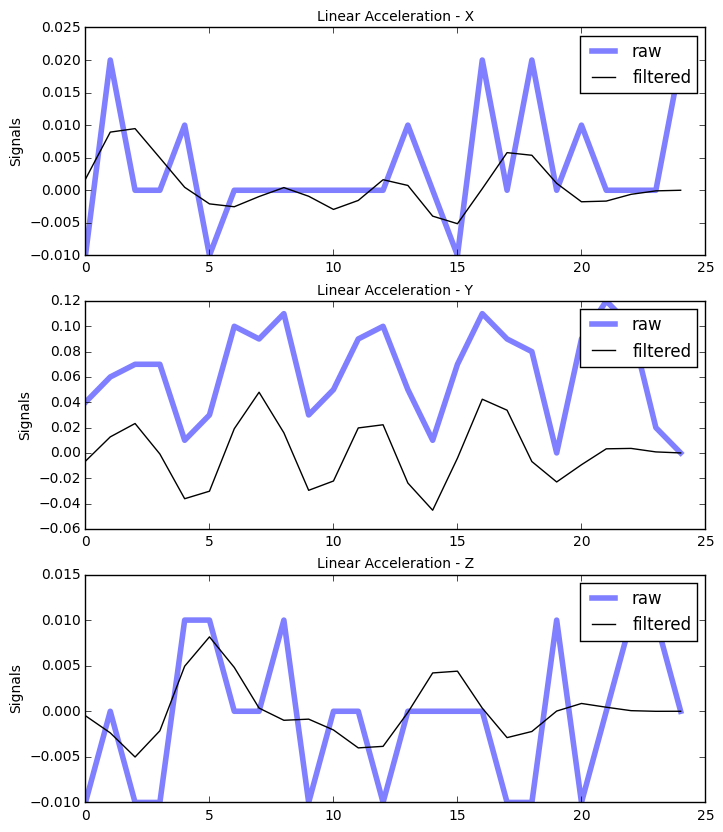

In [20]:
plot_buffered_sensor_data(test_data,2)

### Experiment 1b: Static platform, with calibration

In [21]:
test_data = run_buffered_sensor_read_test(
    buffer_size = 25,
    num_samples=200,
    do_axis_remap=True,
    do_calibration=True)

# Generate some output for debugging
print 'all measurement times:'
for buff_time in test_data['t_data']:
    print '\t'.join(['{:.3f}'.format(t_str) for t_str in buff_time])

Attempting BNO055 calibration
buffer_size:  25
Program ended: Max read attempts exceeded
Program duration (sec): 2.0
Total loop count: 159744
Read attempts: 201
Sensor sample interval (ms): 10.0
Successful reads: 194
Wakeup wrap count: 7
Read success rate: 0.965
all measurement times:
-1483820714.643	-1483820713.643	-1483820712.643	-1483820711.643	-1483820710.643	-1483820709.643	-1483820708.643	-1483820707.643	-1483820706.643	-1483820705.643	-1483820704.643	-1483820703.643	-1483820702.643	-1483820701.643	-1483820700.643	-1483820699.643	-1483820698.643	-1483820697.643	-1483820696.643	-1483820695.643	-1483820694.643	-1483820693.643	-1483820692.643	-1483820691.643	-1483820690.643
1.758	1.767	1.777	1.787	1.797	1.807	1.817	1.827	1.837	1.848	1.857	1.867	1.877	1.887	1.898	1.907	1.917	1.932	1.937	1.948	1.957	1.967	1.978	1.987	1.999
2.007	2.017	2.028	2.038	2.049	2.058	2.068	2.081	2.088	2.099	2.108	2.118	2.128	2.138	2.151	2.159	2.169	2.179	2.189	2.201	2.209	2.219	2.229	2.239	2.253
2.269	2.279	2.

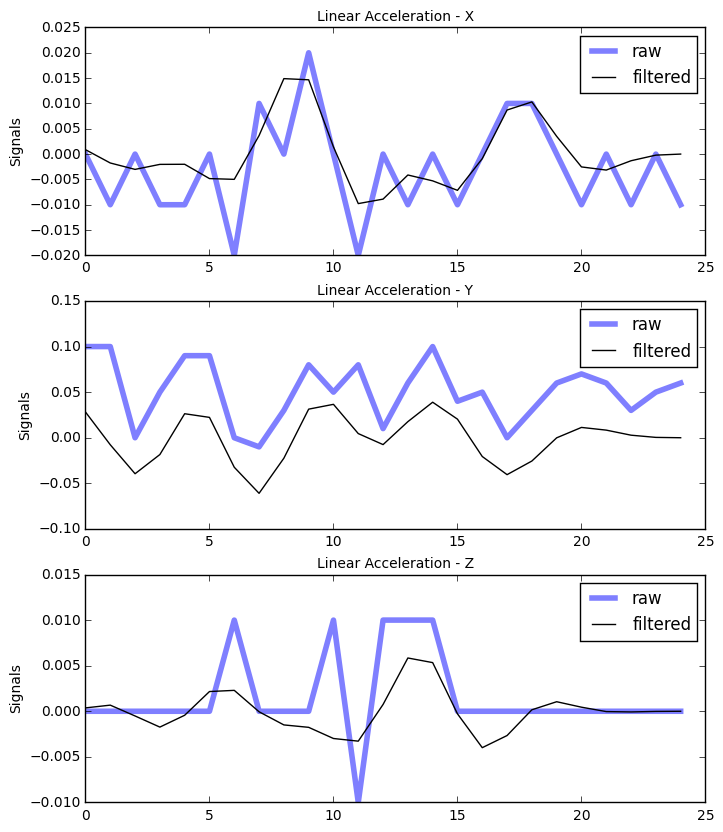

In [22]:
plot_buffered_sensor_data(test_data,2)

### Experiment 2: Manual arbitrary movement

In [23]:
test_data = run_buffered_sensor_read_test(
    buffer_size = 25,
    num_samples=200,
    do_axis_remap=True,
    do_calibration=True)

# Generate some output for debugging
print 'all measurement times:'
for buff_time in test_data['t_data']:
    print '\t'.join(['{:.3f}'.format(t_str) for t_str in buff_time])

Attempting BNO055 calibration
buffer_size:  25
Program ended: Max read attempts exceeded
Program duration (sec): 2.0
Total loop count: 165499
Read attempts: 201
Sensor sample interval (ms): 10.0
Successful reads: 200
Wakeup wrap count: 1
Read success rate: 0.995
all measurement times:
-1483820835.781	-1483820834.781	-1483820833.781	-1483820832.781	-1483820831.781	-1483820830.781	-1483820829.781	-1483820828.781	-1483820827.781	-1483820826.781	-1483820825.781	-1483820824.781	-1483820823.781	-1483820822.781	-1483820821.781	-1483820820.781	-1483820819.781	-1483820818.781	-1483820817.781	-1483820816.781	-1483820815.781	-1483820814.781	-1483820813.781	-1483820812.781	-1483820811.781
1.912	1.916	1.925	1.935	1.945	1.955	1.965	1.975	1.985	1.995	2.005	2.015	2.025	2.035	2.046	2.055	2.065	2.075	2.085	2.095	2.105	2.115	2.125	2.135	2.145
2.155	2.165	2.175	2.185	2.195	2.205	2.215	2.225	2.235	2.245	2.255	2.265	2.275	2.286	2.295	2.305	2.315	2.325	2.335	2.345	2.355	2.366	2.375	2.385	2.395
2.405	2.416	2.

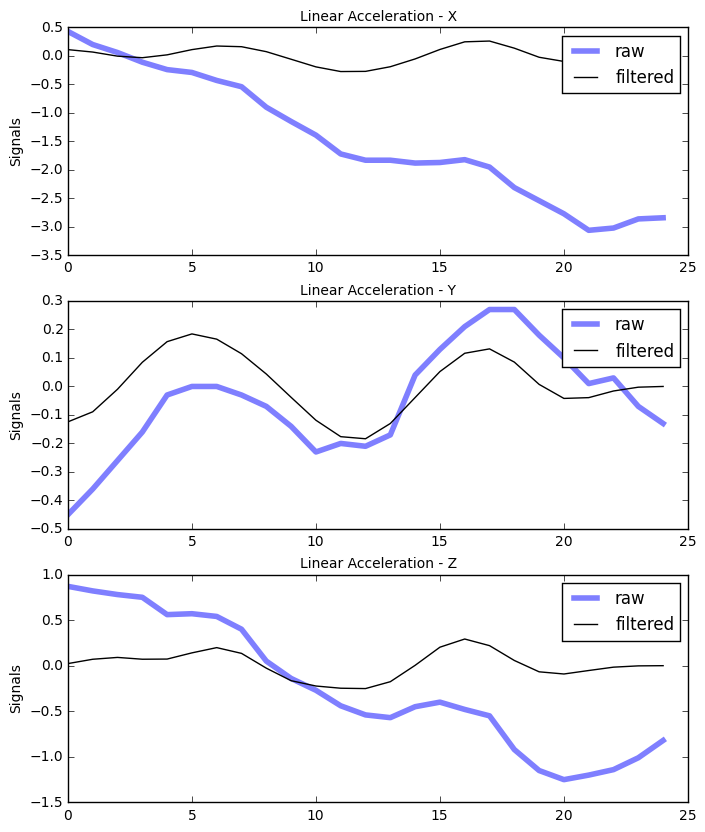

In [25]:
plot_buffered_sensor_data(test_data,2)

### Experiment 3: Simple Automated Drive

In [9]:
# - Main runnable for motor driving process
def drive_test_1(default_speed=10,command_duration_sec=2.0,pause_between_commands_sec=0.2):
    import peripherals.sabertooth.sabertooth_adapter as sabertooth_adapter
    import components.driving.motor_control as motor_control
    
    default_command_duration = 2.0
    default_pause_duration = 0.2
    
    try:
        motorControllerAdapter = sabertooth_adapter.SabertoothPacketizedAdapterGPIO()
        motorController = motor_control.MotorController(motorControllerAdapter)
        
        start_time = time.time()
        
        motorController.goStraight()
        motorController.goForward(default_speed)
        time.sleep(min(default_command_duration,command_duration_sec))
        
        motorControllerAdapter.stop()
        time.sleep(max(default_pause_duration,pause_between_commands_sec))
        
        motorController.goStraight()
        motorController.goBackward(default_speed)
        time.sleep(min(default_command_duration,command_duration_sec))
        
        motorControllerAdapter.stop()
        
        # Increase speed 5%
        #motorController.adjustFwdBwdSetting(5)
        
    finally:
        motorControllerAdapter.stop()
        time.sleep(2)

In [33]:
# - Main test script for Experiment 3
def run_simple_drive_and_sensor_read_test(
    buffer_size = 10,
    num_samples=100,
    do_axis_remap=True,
    do_calibration=False,
    default_drive_power=10,
    default_drive_command_duration_sec=1.0,
    pause_between_commands_sec=0.5):
    
    import multiprocessing as mproc
    import time
    import math

    sample_interval_usec=20000
    max_read_retries=5

    buffer_full_condition = mproc.Condition()
    buffer_mutex = mproc.Lock()

    t_arr = mproc.Array('d', np.zeros(buffer_size))
    x_arr = mproc.Array('d', np.zeros(buffer_size))
    y_arr = mproc.Array('d', np.zeros(buffer_size))
    z_arr = mproc.Array('d', np.zeros(buffer_size))
    buffer_offset = mproc.Value('i',0)

    # - Define IMU Sensor Child Process
    p_sensor = mproc.Process(
        target=run_serial_buffer_test_3, 
        args=(
            num_samples,
            sample_interval_usec,
            max_read_retries,
            t_arr,x_arr,y_arr,z_arr,
            buffer_offset,
            buffer_full_condition,
            buffer_mutex,
            do_axis_remap,
            do_calibration))

    # - Define Motor Controller Child Process
    p_drive = mproc.Process(
        target=drive_test_1, 
        args=(
            default_drive_power, # default_speed
            default_drive_command_duration_sec, # command_duration_sec
            pause_between_commands_sec)) # pause_between_commands_sec
    
    launch_start_time = time.time()
    # First start sensor process (and do a warmup wait so we don't miss the action)
    p_sensor.start()
    time.sleep(0.5)
    # Then start the motor driving process (to generate some dynamical data)
    p_drive.start()

    all_times = []
    all_x_data = []
    all_y_data = []
    all_z_data = []
    for sample_ind in range(int(math.floor(num_samples/buffer_size))):
        # Wait for notification buffer is full
        buffer_full_condition.acquire()
        buffer_full_condition.wait(timeout=1)
        # Lock buffers from being modified while copying and resetting
        buffer_mutex.acquire()
        local_t = t_arr[:]
        local_x = x_arr[:]
        local_y = y_arr[:]
        local_z = z_arr[:]
        buffer_offset.value = 0
        # Unlock buffers
        buffer_mutex.release()
        #time.sleep(0.01)
        buffer_full_condition.release()
        all_times.append([l_t - launch_start_time for l_t in local_t])
        all_x_data.append(local_x)
        all_y_data.append(local_y)
        all_z_data.append(local_z)
    
    p_drive.join(10)
    p_sensor.join(10)

    return {
        't_data':all_times,
        'x_data':all_x_data,
        'y_data':all_y_data,
        'z_data':all_z_data}

# - Main test script for Experiment 3
def run_simple_drive_and_sensor_read_test_2(
    buffer_size = 10,
    num_samples=100,
    sample_interval_usec=20000,
    do_axis_remap=True,
    do_calibration=False,
    default_drive_power=10,
    default_drive_command_duration_sec=1.0,
    pause_between_commands_sec=0.5,
    drive_test_runnable=None,
    drive_test_args=None):
    
    import multiprocessing as mproc
    import time
    import math

    
    max_read_retries=5

    buffer_full_condition = mproc.Condition()
    buffer_mutex = mproc.Lock()

    t_arr = mproc.Array('d', np.zeros(buffer_size))
    x_arr = mproc.Array('d', np.zeros(buffer_size))
    y_arr = mproc.Array('d', np.zeros(buffer_size))
    z_arr = mproc.Array('d', np.zeros(buffer_size))
    buffer_offset = mproc.Value('i',0)

    # - Define IMU Sensor Child Process
    p_sensor = mproc.Process(
        target=run_serial_buffer_test_3, 
        args=(
            num_samples,
            sample_interval_usec,
            max_read_retries,
            t_arr,x_arr,y_arr,z_arr,
            buffer_offset,
            buffer_full_condition,
            buffer_mutex,
            do_axis_remap,
            do_calibration))

    # - Define Motor Controller Child Process
    if drive_test_runnable is None or drive_test_args is None:
        drive_func = drive_test_1
        drive_func_args = (
            default_drive_power, # default_speed
            default_drive_command_duration_sec, # command_duration_sec
            pause_between_commands_sec) # pause_between_commands_sec
    else:
        drive_func = drive_test_runnable
        drive_func_args = drive_test_args
    p_drive = mproc.Process(
        target=drive_func, 
        args=drive_func_args) # command_duration_sec
    
    launch_start_time = time.time()
    # First start sensor process (and do a warmup wait so we don't miss the action)
    p_sensor.start()
    time.sleep(0.2)
    # Then start the motor driving process (to generate some dynamical data)
    p_drive.start()

    all_times = []
    all_x_data = []
    all_y_data = []
    all_z_data = []
    # Wait for notification buffer is full
    buffer_full_condition.acquire()
    buffer_full_condition.wait(timeout=10)
    # Lock buffers from being modified while copying and resetting
    buffer_mutex.acquire()
    all_times.append([l_t - launch_start_time for l_t in t_arr[:]])
    all_x_data.append(x_arr[:])
    all_y_data.append(y_arr[:])
    all_z_data.append(z_arr[:])
    buffer_offset.value = 0
    # Unlock buffers
    buffer_mutex.release()
    #time.sleep(0.01)
    buffer_full_condition.release()
    
    p_drive.join(10)
    p_sensor.join(10)

    return {
        't_data':all_times,
        'x_data':all_x_data,
        'y_data':all_y_data,
        'z_data':all_z_data}

# - Main test script for Experiment 3 (plus quaternions)
def run_simple_drive_and_sensor_read_test_3(
    buffer_size = 10,
    num_samples=100,
    sample_interval_usec=20000,
    do_axis_remap=True,
    do_calibration=False,
    default_drive_power=10,
    default_drive_command_duration_sec=1.0,
    pause_between_commands_sec=0.5,
    drive_test_runnable=None,
    drive_test_args=None):
    
    import multiprocessing as mproc
    import time
    import math

    
    max_read_retries=5

    buffer_full_condition = mproc.Condition()
    buffer_mutex = mproc.Lock()

    t_arr = mproc.Array('d', np.zeros(buffer_size))
    x_arr = mproc.Array('d', np.zeros(buffer_size))
    y_arr = mproc.Array('d', np.zeros(buffer_size))
    z_arr = mproc.Array('d', np.zeros(buffer_size))
    qw_arr = mproc.Array('d', np.zeros(buffer_size))
    qx_arr = mproc.Array('d', np.zeros(buffer_size))
    qy_arr = mproc.Array('d', np.zeros(buffer_size))
    qz_arr = mproc.Array('d', np.zeros(buffer_size))
    buffer_offset = mproc.Value('i',0)

    # - Define IMU Sensor Child Process
    p_sensor = mproc.Process(
        target=run_serial_buffer_test_3, 
        args=(
            num_samples,
            sample_interval_usec,
            max_read_retries,
            t_arr,x_arr,y_arr,z_arr,
            buffer_offset,
            buffer_full_condition,
            buffer_mutex,
            do_axis_remap,
            do_calibration,
            qw_arr,qx_arr,qy_arr,qz_arr))

    # - Define Motor Controller Child Process
    if drive_test_runnable is None or drive_test_args is None:
        drive_func = drive_test_1
        drive_func_args = (
            default_drive_power, # default_speed
            default_drive_command_duration_sec, # command_duration_sec
            pause_between_commands_sec) # pause_between_commands_sec
    else:
        drive_func = drive_test_runnable
        drive_func_args = drive_test_args
    p_drive = mproc.Process(
        target=drive_func, 
        args=drive_func_args) # command_duration_sec
    
    launch_start_time = time.time()
    # First start sensor process (and do a warmup wait so we don't miss the action)
    p_sensor.start()
    time.sleep(0.2)
    # Then start the motor driving process (to generate some dynamical data)
    p_drive.start()

    all_times = []
    all_x_data = []
    all_y_data = []
    all_z_data = []
    all_qw_data = []
    all_qx_data = []
    all_qy_data = []
    all_qz_data = []
    # Wait for notification buffer is full
    buffer_full_condition.acquire()
    buffer_full_condition.wait(timeout=10)
    # Lock buffers from being modified while copying and resetting
    buffer_mutex.acquire()
    all_times.append([l_t - launch_start_time for l_t in t_arr[:]])
    all_x_data.append(x_arr[:])
    all_y_data.append(y_arr[:])
    all_z_data.append(z_arr[:])
    all_qw_data.append(qw_arr[:])
    all_qx_data.append(qx_arr[:])
    all_qy_data.append(qy_arr[:])
    all_qz_data.append(qz_arr[:])
    buffer_offset.value = 0
    # Unlock buffers
    buffer_mutex.release()
    #time.sleep(0.01)
    buffer_full_condition.release()
    
    p_drive.join(10)
    p_sensor.join(10)

    return {
        't_data':all_times,
        'x_data':all_x_data,
        'y_data':all_y_data,
        'z_data':all_z_data,
        'qw_data':all_qw_data,
        'qx_data':all_qx_data,
        'qy_data':all_qy_data,
        'qz_data':all_qz_data}

### Test 3a

In [70]:
test_3a_data = run_simple_drive_and_sensor_read_test(
    buffer_size = 50,
    num_samples=500,
    do_axis_remap=True,
    do_calibration=True,
    default_drive_power=25,
    default_drive_command_duration_sec=1.0,
    pause_between_commands_sec=0.5)

Attempting BNO055 calibration
buffer_size:  50
motor command:  131   2   10   15
motor command:  131   13   64   80
motor command:  131   12   80   95
motor command:  131   0   0   3
motor command:  131   4   0   7
motor command:  131   13   64   80
motor command:  131   12   47   62
motor command:  131   0   0   3
motor command:  131   4   0   7
motor command:  131   0   0   3
motor command:  131   4   0   7
Program ended: Max read attempts exceeded
Program duration (sec): 10.1
Total loop count: 755497
Read attempts: 501
Sensor sample interval (ms): 20.0
Successful reads: 490
Wakeup wrap count: 11
Read success rate: 0.978


In [71]:
#test_3c_data['t_data']
frame_ind = 0
for test_data in test_3a_data['x_data']:
    if -99.0 in test_data:
        print 'dropped sample in frame ',frame_ind
    frame_ind += 1

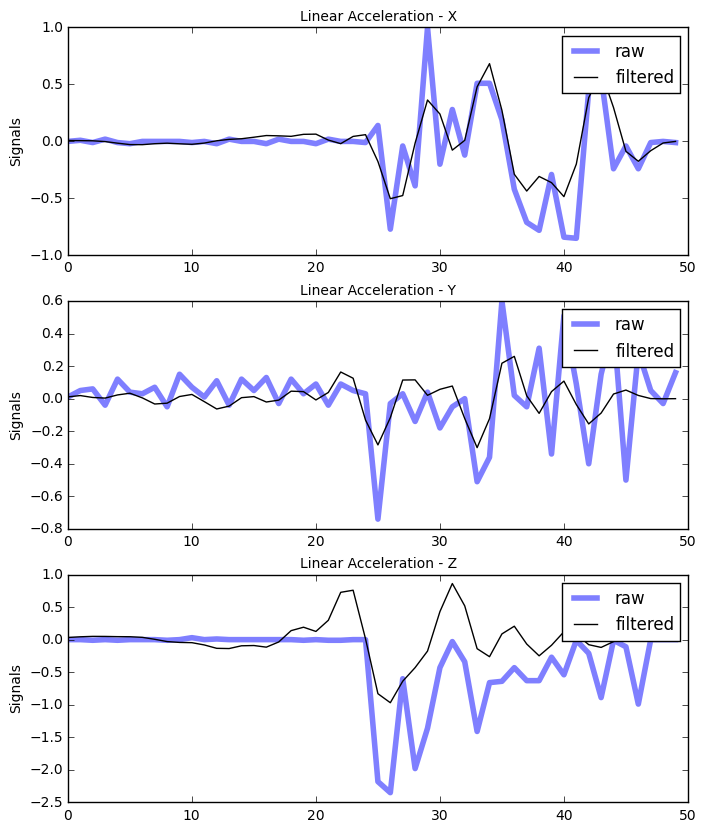

In [75]:
plot_buffered_sensor_data(test_3a_data,3)
#plot_buffered_sensor_data(test_3a_data,1,y1lim=[-1,1],y2lim=[-1,1],y3lim=[-1,1])
#plot_buffered_sensor_data(test_3a_data,1,y1lim=[-0.1,0.1],y2lim=[-0.2,0.2],y3lim=[-0.1,0.1])
#plot_buffered_sensor_data(test_3a_data,1,y1lim=[-10,10],y2lim=[-10,10],y3lim=[-10,10])

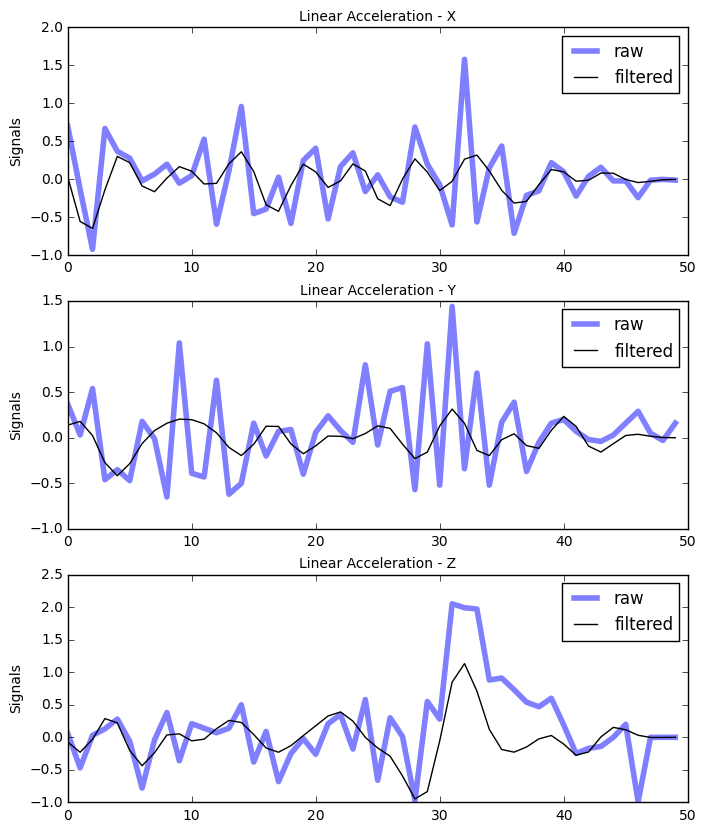

In [76]:
plot_buffered_sensor_data(test_3a_data,4)

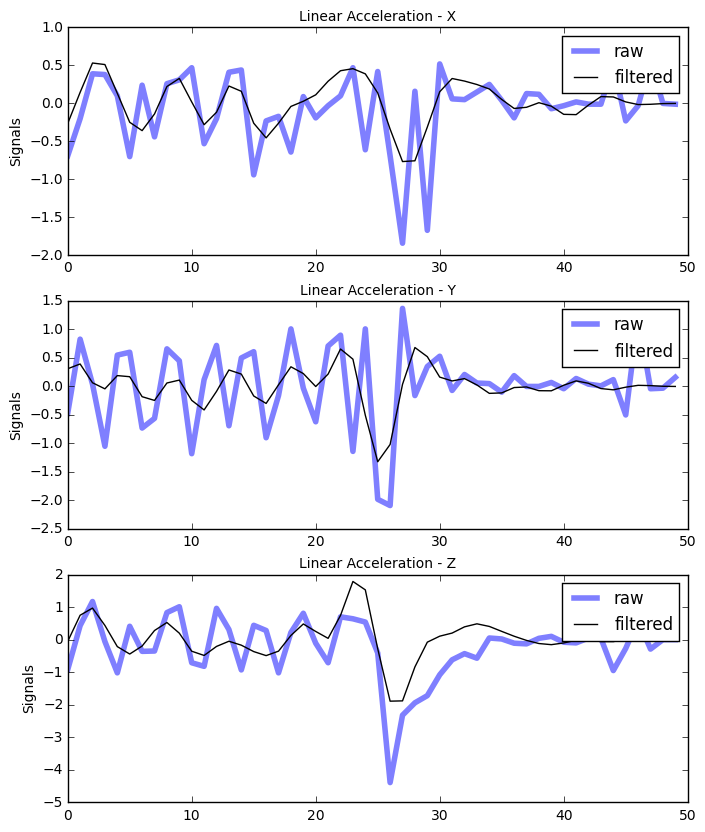

In [79]:
plot_buffered_sensor_data(test_3a_data,6)

#### Observations
- It is proving difficult to get the sensor measurement frames (sets of consecutive samples) to capture the signature of the scripted drive commands.  The frames shown above show some relatively large, one sided signal peaks in the z-axis.  It is hard to map the timing of these peaks to the known drive commands.

### Test 3b
- Update BNO axis mapping since Test 3a.  Switched X and Z.
- Switch to run_simple_drive_and_sensor_read_test_2, which does a single long measurement frame.  It should be sufficient to capture the whole scripted drive process in a single frame

In [37]:
test_3b_data = run_simple_drive_and_sensor_read_test_2(
    buffer_size = 400,
    num_samples=1000,
    do_axis_remap=True,
    do_calibration=True,
    default_drive_power=25,
    default_drive_command_duration_sec=0.5,
    pause_between_commands_sec=2.0)

Attempting BNO055 calibration
buffer_size:  400
motor command:  131   2   10   15
motor command:  131   13   64   80
motor command:  131   12   80   95
motor command:  131   0   0   3
motor command:  131   4   0   7
motor command:  131   13   64   80
motor command:  131   12   47   62
motor command:  131   0   0   3
motor command:  131   4   0   7
motor command:  131   0   0   3
motor command:  131   4   0   7
Program ended: Max read attempts exceeded
Program duration (sec): 20.0
Total loop count: 1729313
Read attempts: 1001
Sensor sample interval (ms): 20.0
Successful reads: 990
Wakeup wrap count: 11
Read success rate: 0.989


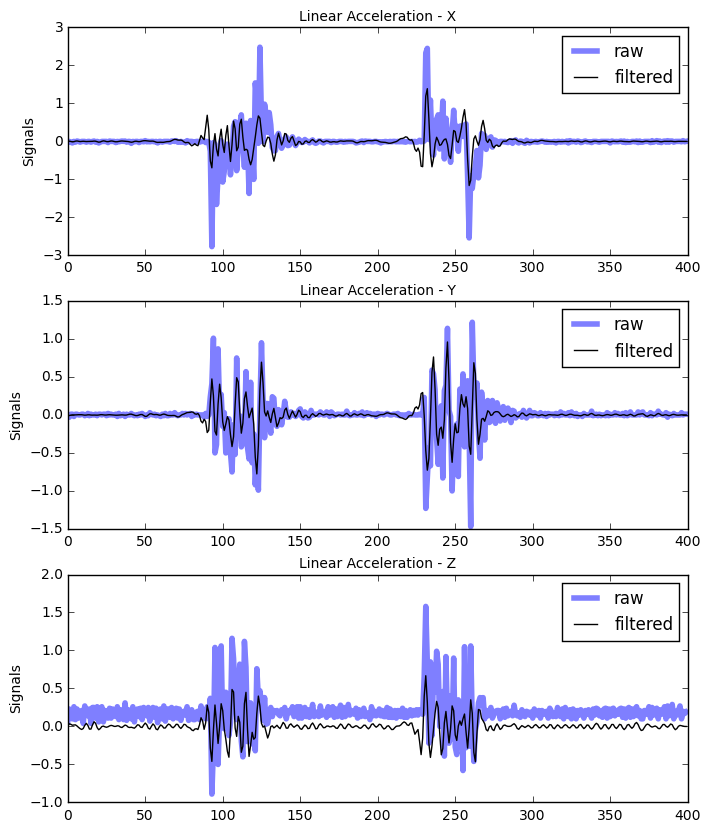

In [38]:
plot_buffered_sensor_data(test_3b_data,0)

#### Observations
- New script successfully captured full drive sequence in a single sensor frame
- Remapping the sensor axes successfully mapped the forward-reverse axis to 'X', but the apparent inversion of positive-negative values wasn't successfully avoided.  Not sure why the X-axis sign inversion is happening.  

### Test 3c
- New drive function with two step forward acceleration. E.g., drive forward at 25% power for 2 seconds, then increase to forward at 50% power for 2 seconds, then stop.

In [11]:
def drive_test_2(
    default_speed=10.0,
    command_duration_sec=2.0,
    speed_increase_percent=10.0):
    
    import peripherals.sabertooth.sabertooth_adapter as sabertooth_adapter
    import components.driving.motor_control as motor_control
    
    max_command_duration = 2.0
    max_speed_increase_percent = 20.0
    
    try:
        motorControllerAdapter = sabertooth_adapter.SabertoothPacketizedAdapterGPIO()
        motorController = motor_control.MotorController(motorControllerAdapter)
        
        start_time = time.time()
        
        motorController.goStraight()
        motorController.goForward(default_speed)
        time.sleep(min(
                max_command_duration,
                command_duration_sec))
        
        # Increase speed by percentage
        motorController.adjustFwdBwdSetting(min(
                max_speed_increase_percent,
                speed_increase_percent))
        time.sleep(min(
                max_command_duration,
                command_duration_sec))
        
        motorControllerAdapter.stop()
        
        
    finally:
        motorControllerAdapter.stop()
        time.sleep(2)

In [61]:
test_3c_data = run_simple_drive_and_sensor_read_test_2(
    buffer_size = 400,
    num_samples=1000,
    do_axis_remap=True,
    do_calibration=True,
    default_drive_power=25,
    default_drive_command_duration_sec=0.5,
    pause_between_commands_sec=2.0,
    drive_test_runnable=drive_test_2,
    drive_test_args=(
        25.0, # default_speed
        2.0, # command_duration_sec
        25.0)) # speed_increase_percent

Attempting BNO055 calibration
buffer_size:  400
motor command:  131   2   10   15
motor command:  131   13   64   80
motor command:  131   12   80   95
motor command:  131   12   92   107
motor command:  131   0   0   3
motor command:  131   4   0   7
motor command:  131   0   0   3
motor command:  131   4   0   7
Program ended: Max read attempts exceeded
Program duration (sec): 20.0
Total loop count: 1788007
Read attempts: 1001
Sensor sample interval (ms): 20.0
Successful reads: 992
Wakeup wrap count: 9
Read success rate: 0.991


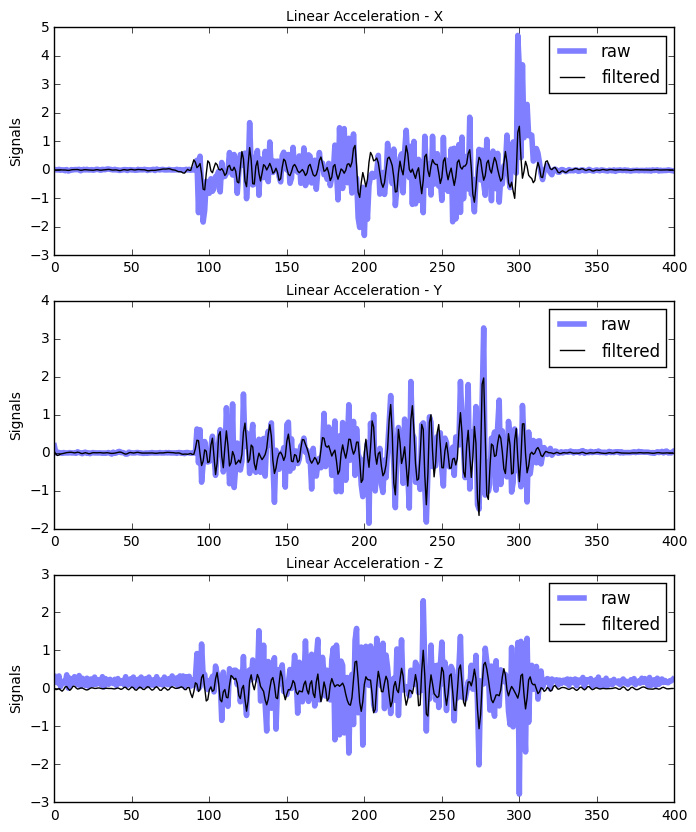

In [62]:
plot_buffered_sensor_data(test_3c_data,0)

#### Observations
- Data in x-axis graph show significant peaks at the two acceleration times and the stop time.
- It is surprising that the "noise" in the x-axis is so similar in magnitude to the peaks known to be caused by commanded changes
- It is surprising the "noise" in the y-axis and z-axis is so similar in magitude to the commanded peaks in the x-axis.
- The filtered signals don't seem particularly usefull (not very discriminative of true macro dynamics vs. noise and signal processing artifacts).  Will have to put more time into filter tuning and revisit main sensor sampling rate (currently set to 20ms).

### Test 3d
- Generate and store data sets for offline analysis

In [32]:
import datetime
import pandas as pd
data_file_base_name = '/home/pi/nanibot/sandboxes/data/rover_imu_test_data_Test3d'

In [50]:
test_3d_data = run_simple_drive_and_sensor_read_test_2(
    buffer_size = 500,
    num_samples=1000,
    do_axis_remap=True,
    do_calibration=True,
    default_drive_power=25,
    default_drive_command_duration_sec=2.0,
    pause_between_commands_sec=2.0)

Attempting BNO055 calibration
buffer_size:  500
motor command:  131   2   10   15
motor command:  131   13   64   80
motor command:  131   12   80   95
motor command:  131   0   0   3
motor command:  131   4   0   7
motor command:  131   13   64   80
motor command:  131   12   47   62
motor command:  131   0   0   3
motor command:  131   4   0   7
motor command:  131   0   0   3
motor command:  131   4   0   7
Program ended: Max read attempts exceeded
Program duration (sec): 20.0
Total loop count: 1547040
Read attempts: 1001
Sensor sample interval (ms): 20.0
Successful reads: 990
Wakeup wrap count: 11
Read success rate: 0.989


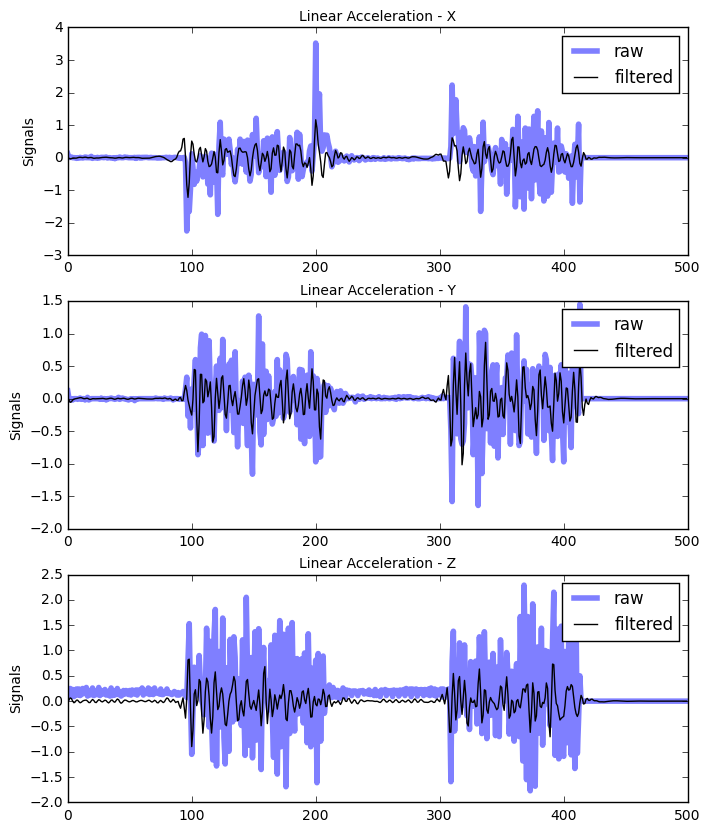

In [51]:
plot_buffered_sensor_data(test_3d_data,0)

In [52]:
# Repackage test data for writing to csv via Pandas
prepared_data = pd.DataFrame({
        't':test_3d_data['t_data'][0],
        'x':test_3d_data['x_data'][0],
        'y':test_3d_data['y_data'][0],
        'z':test_3d_data['z_data'][0]},
        index=range(len(test_3d_data['t_data'][0])))
# - Write data to file
log_time_str = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
prepared_data.to_csv(
    '{base_str}_{time_str}.csv'.format(base_str=data_file_base_name,time_str=log_time_str),
    index=False,
    encoding='utf-8')

### Test 3e

In [12]:
import datetime
import pandas as pd
data_file_base_name = '/home/pi/nanibot/sandboxes/data/rover_imu_test_data_Test3e'

In [50]:
def make_prepared_data_df(test_data,frame_ind=0):
    prepared_data = pd.DataFrame({
        't':test_data['t_data'][frame_ind],
        'x':test_data['x_data'][frame_ind],
        'y':test_data['y_data'][frame_ind],
        'z':test_data['z_data'][frame_ind]},
        index=range(len(test_data['t_data'][frame_ind])))
    if 'qw_data' in test_data.keys():
        prepared_data = prepared_data.join(
            pd.DataFrame({
                'qw':test_data['qw_data'][frame_ind],
                'qx':test_data['qx_data'][frame_ind],
                'qy':test_data['qy_data'][frame_ind],
                'qz':test_data['qz_data'][frame_ind]},
                index=range(len(test_data['t_data'][frame_ind]))),
            how='inner')
    return prepared_data

def log_test_data_to_file(test_data,data_file_base_name):
    # Repackage test data for writing to csv via Pandas
    prepared_data = make_prepared_data_df(test_data,frame_ind=0)
    # - Write data to file
    log_time_str = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    prepared_data.to_csv(
        '{base_str}_{time_str}.csv'.format(base_str=data_file_base_name,time_str=log_time_str),
        index=False,
        encoding='utf-8')

In [56]:
test_3e_data = run_simple_drive_and_sensor_read_test_3(
    buffer_size = 500,
    num_samples=1000,
    sample_interval_usec=20000,
    do_axis_remap=True,
    do_calibration=True,
    default_drive_power=15,
    default_drive_command_duration_sec=2.0,
    pause_between_commands_sec=2.0)

Attempting BNO055 calibration
buffer_size:  500
motor command:  131   2   10   15
motor command:  131   13   64   80
motor command:  131   12   74   89
motor command:  131   0   0   3
motor command:  131   4   0   7
motor command:  131   13   64   80
motor command:  131   12   53   68
motor command:  131   0   0   3
motor command:  131   4   0   7
motor command:  131   0   0   3
motor command:  131   4   0   7
Unknown exception on wakeup: 549
<class 'select.error'>
(4, 'Interrupted system call')
about to release lock in child due to exception, buffer offset:  123
Unknown exception on wakeup: 592
<class 'select.error'>
(4, 'Interrupted system call')
about to release lock in child due to exception, buffer offset:  165
Program ended: Max read attempts exceeded
Program duration (sec): 20.4
Total loop count: 1087991
Read attempts: 1001
Sensor sample interval (ms): 20.0
Successful reads: 972
Wakeup wrap count: 29
Read success rate: 0.971


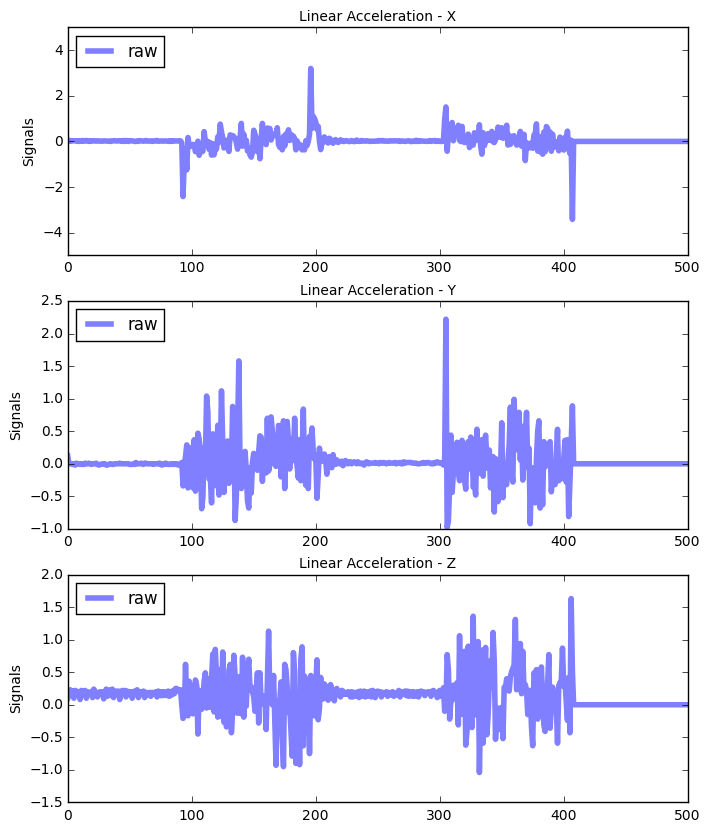

In [57]:
test_data_df = make_prepared_data_df(test_3e_data,frame_ind=0)
plot_raw_and_processed_data(test_data_df,y1lim=(-5,5))

In [58]:
log_test_data_to_file(test_3e_data,data_file_base_name)

## Sandbox

In [171]:
p.is_alive()

False

In [110]:
p.join()

In [198]:
%matplotlib inline
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

numerator:  [ 0.0527864   0.26393202  0.52786405  0.52786405  0.26393202  0.0527864 ]
denominator:  [  1.00000000e+00  -4.16333634e-16   6.33436854e-01  -1.31860534e-16
   5.57280900e-02  -3.09353043e-18]


(-500, 50)

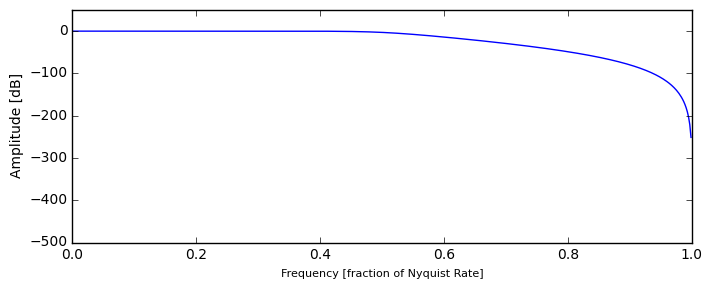

In [216]:
b, a = signal.butter(5, 0.5, 'low', analog=False)
w, h = signal.freqz(b,a)

print 'numerator: ',b
print 'denominator: ',a

fig, axes = plt.subplots(figsize=(8,3),nrows=1, ncols=1)
current_axes = axes
current_axes.plot(w/math.pi, 20 * np.log10(abs(h)), 'b')
current_axes.set_ylabel('Amplitude [dB]', fontsize=10)
current_axes.set_xlabel('Frequency [fraction of Nyquist Rate]', fontsize=8)
current_axes.set_ylim([-500,50])

numerator:  [ 0.7753166   3.87658298  7.75316595  7.75316595  3.87658298  0.7753166 ]
denominator:  [ 1.          4.49183097  8.09405542  7.31208128  3.31104756  0.60111582]


(-500, 50)

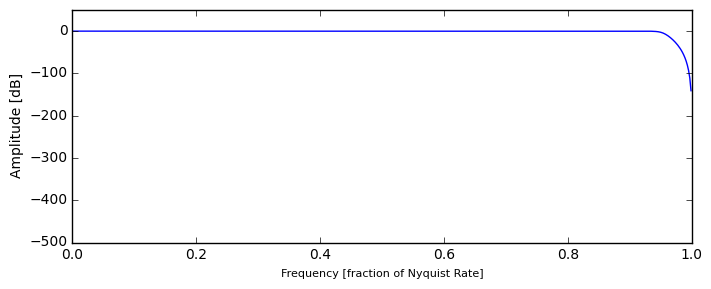

In [218]:
b, a = signal.butter(5, 0.95, 'low', analog=False)
w, h = signal.freqz(b,a)

print 'numerator: ',b
print 'denominator: ',a

fig, axes = plt.subplots(figsize=(8,3),nrows=1, ncols=1)
current_axes = axes
current_axes.plot(w/math.pi, 20 * np.log10(abs(h)), 'b')
current_axes.set_ylabel('Amplitude [dB]', fontsize=10)
current_axes.set_xlabel('Frequency [fraction of Nyquist Rate]', fontsize=8)
current_axes.set_ylim([-500,50])

numerator:  [ 0.5999402   0.         -2.99970102  0.          5.99940204  0.
 -5.99940204  0.          2.99970102  0.         -0.5999402 ]
denominator:  [  1.00000000e+00  -1.77635684e-15  -3.98454312e+00   2.66453526e-15
   6.43486709e+00  -7.10542736e-15  -5.25361517e+00  -1.11022302e-15
   2.16513291e+00  -3.33066907e-16  -3.59928245e-01]


(-500, 50)

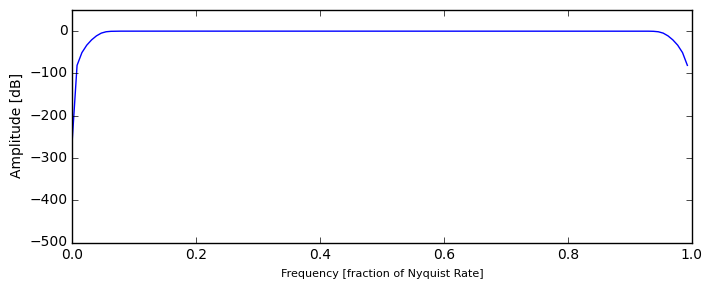

In [238]:
b, a = signal.butter(5, [0.05,0.95], 'bandpass', analog=False)
w, h = signal.freqz(b,a,128)

print 'numerator: ',b
print 'denominator: ',a

fig, axes = plt.subplots(figsize=(8,3),nrows=1, ncols=1)
current_axes = axes
current_axes.plot(w/math.pi, 20 * np.log10(abs(h)), 'b')
current_axes.set_ylabel('Amplitude [dB]', fontsize=10)
current_axes.set_xlabel('Frequency [fraction of Nyquist Rate]', fontsize=8)
current_axes.set_ylim([-500,50])

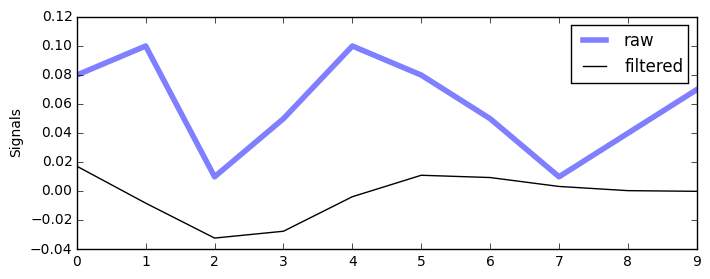

In [267]:
#sig_data = all_x_data[0]
#sig_data = all_y_data[0]
sig_data = all_z_data[0]

b, a = signal.butter(5, [0.1,0.50], 'bandpass', analog=False)
filt_data = signal.filtfilt(b,a,sig_data,padtype='odd',padlen=0)
#b, a = signal.butter(5, [0.95], 'low', analog=False)
#filt_data = signal.filtfilt(b,a,sig_data,padtype='odd',padlen=0)
#b, a = signal.butter(5, [0.05], 'high', analog=False)
#filt_data = signal.filtfilt(b,a,sig_data,padtype='odd',padlen=0)

fig, axes = plt.subplots(figsize=(8,3),nrows=1, ncols=1)
current_axes = axes
current_axes.plot(sig_data, linestyle='-', color='b', linewidth=4, alpha=0.5, label='raw')
current_axes.plot(filt_data, linestyle='-', color='k', linewidth=1, alpha=1.0, label='filtered')
current_axes.set_ylabel('Signals', fontsize=10)
current_axes.legend(loc='upper right')
#current_axes.set_xlabel('Frequency [fraction of Nyquist Rate]', fontsize=8)
#current_axes.set_ylim([-500,50])

In [15]:
import peripherals.sabertooth.sabertooth_adapter as sabertooth_adapter
import components.driving.motor_control as motor_control

dummy = """
# --- Sabertooth Command Definitions ---
M1_FWD = 0
M1_BWD = 1
MIN_VOLTAGE_COMMAND = 2
M2_FWD = 4
M2_BWD = 5
M1_DRIVE = 6
M2_DRIVE = 7
MIXED_FWD = 8
MIXED_BWD = 9
MIXED_R_TURN = 10
MIXED_L_TURN = 11
MIXED_BWD_FWD = 12
MIXED_LR_TURN = 13

# --- Sabertooth Command Depths
MIXED_FWD_STOP, MIXED_BWD_STOP, MIXED_R_STOP, MIXED_L_STOP, MIXED_LR_STRAIGHT = 64, 64, 64, 64, 64
MIXED_FWD_MIN = 65
MIXED_FWD_MAX = 127
MIXED_BWD_MIN = 63
MIXED_BWD_MAX = 0
MIXED_R_MIN = 65
MIXED_R_MAX = 127
MIXED_L_MIN = 63
MIXED_L_MAX = 0
"""

In [16]:
reload(sabertooth_adapter)
reload(motor_control)

<module 'components.driving.motor_control' from '/home/pi/nanibot/rover1/components/driving/motor_control.pyc'>

In [22]:
motorControllerAdapter = sabertooth_adapter.SabertoothPacketizedAdapterGPIO()
motorController = motor_control.MotorController(motorControllerAdapter)

NameError: name 'sabertooth_adapter' is not defined

In [32]:
motorControllerAdapter.do_moving_mixed_mode_test()

motor command:  131   12   75   90
motor command:  131   13   64   80
motor command:  131   13   74   90
motor command:  131   13   49   65
motor command:  131   13   64   80
motor command:  131   13   75   91
motor command:  131   13   64   80
motor command:  131   12   54   69
motor command:  131   12   49   64
motor command:  131   0   0   3
motor command:  131   4   0   7


In [28]:
def sandbox_drive_test_1(default_speed=10,command_duration_sec=2.0):
    import peripherals.sabertooth.sabertooth_adapter as sabertooth_adapter
    import components.driving.motor_control as motor_control
    
    default_command_duration = 2.0
    
    try:
        motorControllerAdapter = sabertooth_adapter.SabertoothPacketizedAdapterGPIO()
        motorController = motor_control.MotorController(motorControllerAdapter)
        
        start_time = time.time()
        
        motorController.goStraight()
        motorController.goForward(default_speed)
        time.sleep(min(default_command_duration,command_duration_sec))
        
        motorControllerAdapter.stop()
        time.sleep(0.5)
        
        motorController.goStraight()
        motorController.goBackward(default_speed)
        time.sleep(min(default_command_duration,command_duration_sec))
        
        motorControllerAdapter.stop()
        
        # Increase speed 5%
        #motorController.adjustFwdBwdSetting(5)
        
    finally:
        motorControllerAdapter.stop()
        time.sleep(2)
        
def drive_fwd_test(default_speed=10):
    import peripherals.sabertooth.sabertooth_adapter as sabertooth_adapter
    import components.driving.motor_control as motor_control
    
    try:
        motorControllerAdapter = sabertooth_adapter.SabertoothPacketizedAdapterGPIO()
        motorController = motor_control.MotorController(motorControllerAdapter)
        
        start_time = time.time()
        
        motorController.goStraight()
        motorController.goForward(default_speed)
        time.sleep(2)
        
        motorControllerAdapter.stop()
        
    finally:
        motorControllerAdapter.stop()
        time.sleep(2)
        
def drive_bwd_test(default_speed=10):
    import peripherals.sabertooth.sabertooth_adapter as sabertooth_adapter
    import components.driving.motor_control as motor_control
    
    try:
        motorControllerAdapter = sabertooth_adapter.SabertoothPacketizedAdapterGPIO()
        motorController = motor_control.MotorController(motorControllerAdapter)
        
        start_time = time.time()
        
        motorController.goStraight()
        motorController.goBackward(default_speed)
        time.sleep(2)
        
        motorControllerAdapter.stop()
        
    finally:
        motorControllerAdapter.stop()
        time.sleep(2)

In [20]:
sandbox_drive_test_1(default_speed=25,command_duration_sec=1.0)

motor command:  131   2   10   15
motor command:  131   13   64   80
motor command:  131   12   80   95
motor command:  131   0   0   3
motor command:  131   4   0   7
motor command:  131   13   64   80
motor command:  131   12   47   62
motor command:  131   0   0   3
motor command:  131   4   0   7
motor command:  131   0   0   3
motor command:  131   4   0   7


In [25]:
drive_fwd_test(default_speed=25)

motor command:  131   2   10   15
motor command:  131   13   64   80
motor command:  131   12   80   95
motor command:  131   0   0   3
motor command:  131   4   0   7
motor command:  131   0   0   3
motor command:  131   4   0   7


In [22]:
drive_bwd_test(default_speed=25)

motor command:  131   2   10   15
motor command:  131   13   64   80
motor command:  131   12   47   62
motor command:  131   0   0   3
motor command:  131   4   0   7
motor command:  131   0   0   3
motor command:  131   4   0   7


In [21]:
np.zeros(50)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])